In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def load_stock_data(file_path):
    # Φόρτωση του αρχείου CSV σε DataFrame
    df = pd.read_csv(file_path, parse_dates=['time'])

    # Αφαίρεση της στήλης 'complete'
    df.drop(columns=['complete'], inplace=True, errors='ignore')
    
    # Ορισμός της στήλης 'time' ως index
    df.set_index('time', inplace=True)
    
    # Μετονομασία των στηλών
    df.rename(columns={'volume': 'Volume', 'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close'}, inplace=True)
    
    return df

# def get_records_for_period(df, start_date, end_date):
#     """
#     Επιστρέφει το πλήθος εγγραφών για κάθε ημέρα εντός του δοσμένου διαστήματος.
#     """
#     period_data = df.loc[start_date:end_date]
#     records_per_day = period_data.resample('D').size()
#     return records_per_day.reset_index().rename(columns={'time': 'date', 0: 'count'})

def plot_records_distribution(df):
    """
    Δημιουργεί διάγραμμα συχνότητας των εγγραφών για το σύνολο των δεδομένων.
    """
    records_per_day = df.resample('D').size().reset_index()
    records_per_day.columns = ['date', 'count']
    plt.figure(figsize=(12, 6))
    bars = plt.bar(records_per_day['date'], records_per_day['count'], color='blue')
    plt.xlabel('Ημερομηνία')
    plt.ylabel('Πλήθος Εγγραφών')
    plt.title(f'Κατανομή Εγγραφών')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Εμφάνιση του αριθμού εγγραφών πάνω από κάθε μπάρα
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height,
            f'{int(height)}',
            ha='center', va='bottom',
            fontsize=12,      # Μεγαλύτερη γραμματοσειρά
            # rotation=90       # Περιστροφή κειμένου
        )

    plt.tight_layout()
    plt.show()

def plot_stock_prices(df):
    """
    Δημιουργεί διάγραμμα με τις τιμές των μετοχών (κλείσιμο) για το σύνολο του DataFrame.
    Προσθέτει σκίαση ανά ημέρα ή εβδομάδα.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index.to_numpy(), df['Close'].to_numpy(), color='green', linestyle='-', marker='o')
    
    # Προσθήκη σκίασης ανά ημέρα
    for i, date in enumerate(pd.date_range(start=df.index.min(), end=df.index.max())):
        if i % 2 == 0:
            ax.axvspan(date, date + pd.Timedelta(days=1), color='gray', alpha=0.2)
    
    ax.set_xlabel('Ημερομηνία')
    ax.set_ylabel('Τιμή Κλεισίματος')
    ax.set_title(f'Τιμές Κλεισίματος')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
        
def get_stock_data_for_period(df, start_date, end_date, frequency):
    """
    Επιστρέφει τις τιμές των μετοχών για το δοσμένο χρονικό διάστημα με ανάλυση δείγματος σε λεπτά.
    Αν frequency = 0, επιστρέφει τα αρχικά δεδομένα χωρίς δειγματοληψία.
    Αν υπάρχουν άλματα στις ημερομηνίες, ενσωματώνει την πλησιέστερη διαθέσιμη εγγραφή.
    Ενημερώνει την τιμή volume με το άθροισμα όλων των τιμών που παραλήφθηκαν.
    Το low και high είναι το μικρότερο low και το μεγαλύτερο high από τις παραληφθείσες τιμές.
    """
    period_data = df.loc[start_date:end_date].copy()
    
    if frequency == 0:
        return period_data
    
    sampled_data = []
    last_time = None
    temp_group = []
    
    for time, row in period_data.iterrows():
        if last_time is None or (time - last_time).total_seconds() / 60 >= frequency:
            if temp_group:
                sampled_row = temp_group[0].copy()
                sampled_row['Volume'] = sum(r['Volume'] for r in temp_group)
                sampled_row['Low'] = min(r['Low'] for r in temp_group)
                sampled_row['High'] = max(r['High'] for r in temp_group)
                sampled_data.append(sampled_row)
            temp_group = []
            last_time = time
        temp_group.append(row)
    
    if temp_group:
        sampled_row = temp_group[0].copy()
        sampled_row['Volume'] = sum(r['Volume'] for r in temp_group)
        sampled_row['Low'] = min(r['Low'] for r in temp_group)
        sampled_row['High'] = max(r['High'] for r in temp_group)
        sampled_data.append(sampled_row)
    
    return pd.DataFrame(sampled_data)

In [78]:
# Παράδειγμα χρήσης
file_path = 'myBTC_USD_M1_A (2023_08_09 09_27_40 UTC).csv'  
stock_df = load_stock_data(file_path)
stock_df.index = stock_df.index + pd.Timedelta(hours=2)  # Προσαρμογή ώρας UTC+2

# Εμφάνιση των πρώτων γραμμών
print(stock_df.head())

                           Volume   Open   High    Low  Close
time                                                         
2016-01-01 07:01:00+00:00      23  439.3  439.3  439.1  439.1
2016-01-01 07:02:00+00:00      23  439.1  439.1  439.1  439.1
2016-01-01 07:03:00+00:00      24  439.1  439.1  439.1  439.1
2016-01-01 07:04:00+00:00      15  439.1  439.1  439.1  439.1
2016-01-01 07:05:00+00:00      14  439.1  439.1  439.1  439.1


## Train period

Πλήθος τιμών χωρίς δειγματοληψία: 14280.0


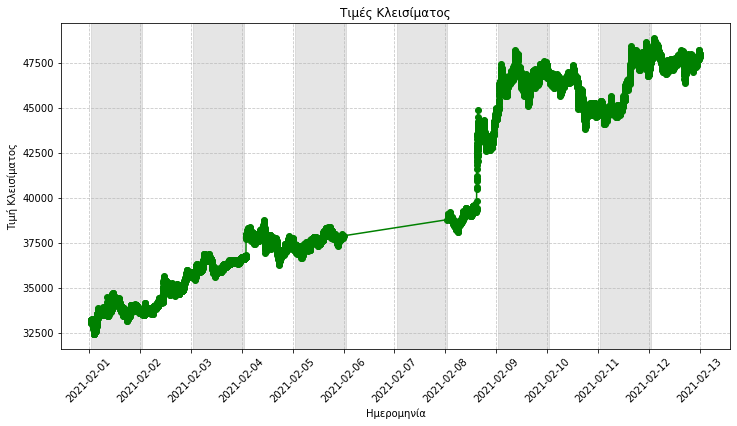

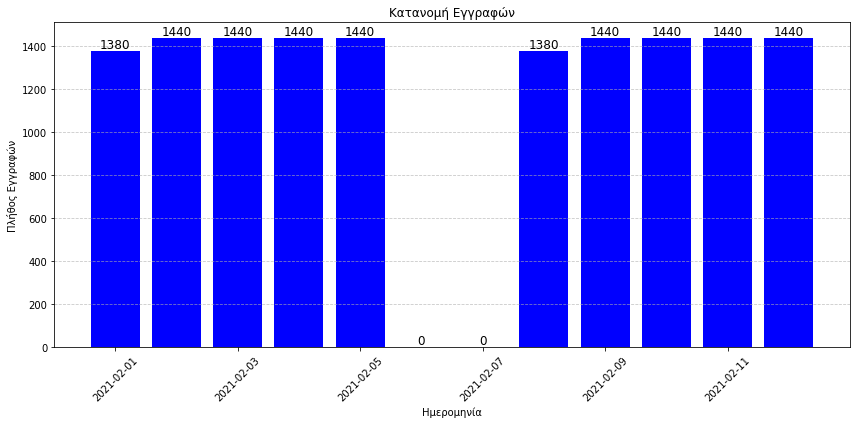

Πλήθος τιμών μετά από δειγματοληψία κάθε 240 λεπτά: 60.0


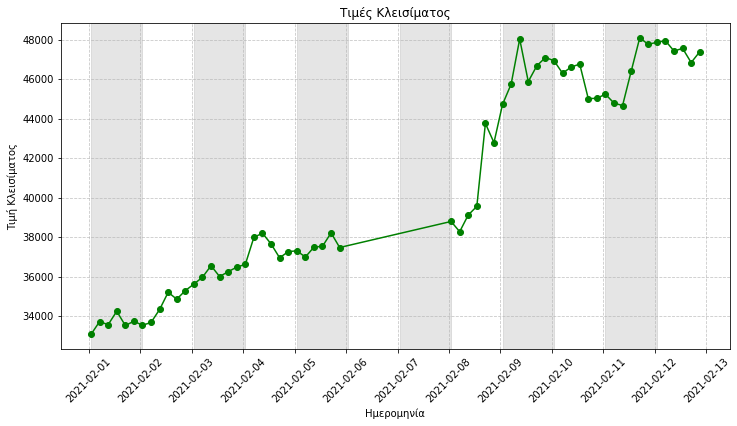

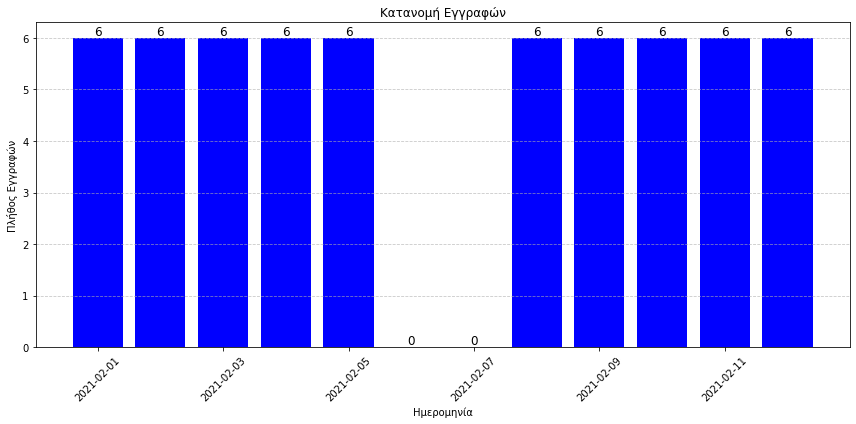

In [88]:
start_date = '2021-02-01'
end_date = '2021-02-14'

# # Απόκτηση δεδομένων τιμών μετοχών για το συγκεκριμένο διάστημα χωρίς δειγματοληψία
frequency = 0
stock_data_period_0 = get_stock_data_for_period(stock_df, start_date, end_date, frequency)
print("Πλήθος τιμών χωρίς δειγματοληψία:", stock_data_period_0.size/5)

# Σχεδίαση κατανομής και τιμών κλεισίματος για το δοσμένο διάστημα
plot_stock_prices(stock_data_period_0)
plot_records_distribution(stock_data_period_0)


# Απόκτηση δεδομένων τιμών μετοχών για το συγκεκριμένο διάστημα με ανάλυση 235 λεπτών
frequency = 240  # Ανάλυση κάθε 240 λεπτά (4 ώρες)
stock_data_period_235 = get_stock_data_for_period(stock_df, start_date, end_date, frequency)
print("Πλήθος τιμών μετά από δειγματοληψία κάθε", frequency, "λεπτά:", stock_data_period_235.size/5)

plot_stock_prices(stock_data_period_235)
plot_records_distribution(stock_data_period_235)